# Part of Speech Tagging

## Table of Content
- ### [Part of Speech Taggings](#post)
- ### [Hidden Markov Model](#hmm)
- ### [Viterbi Algorithm](#viter)
    - #### [1. Initialization](#init)
    - #### [2. Feed Forward](#frwd)
    - #### [3. Feed Backward](#back)

In [1]:
# Import Packages
from utils_pos import get_word_tag, preprocess  
import pandas as pd
from collections import defaultdict
import math
import numpy as np

 - Loading training corpus

In [48]:
with open("WSJ_02-21.pos", 'r') as f:
    training_corpus = f.readlines()

f"Few examples of training corpus: {training_corpus[0:5]}"

"Few examples of training corpus: ['In\\tIN\\n', 'an\\tDT\\n', 'Oct.\\tNNP\\n', '19\\tCD\\n', 'review\\tNN\\n']"

- Reading the Vocabulary data

In [49]:
with open("hmm_vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

f"Few examples of vocabulary list: {voc_l[0:20]}"



'Few examples of vocabulary list: [\'!\', \'#\', \'$\', \'%\', \'&\', "\'", "\'\'", "\'40s", "\'60s", "\'70s", "\'80s", "\'86", "\'90s", "\'N", "\'S", "\'d", "\'em", "\'ll", "\'m", "\'n\'"]'

- vocab: a dictionary that has the index of the corresponding words

In [50]:
vocab = {}
for i,word in enumerate(sorted(voc_l)):
    vocab[word]=i

print(list(vocab.items())[:10])

[('', 0), ('!', 1), ('#', 2), ('$', 3), ('%', 4), ('&', 5), ("'", 6), ("''", 7), ("'40s", 8), ("'60s", 9)]


- Loading the test corpus

In [51]:
with open("WSJ_24.pos", 'r') as f:
    y = f.readlines()

f"Few examples of test corpus: {y[:5]}"


'Few examples of test corpus: [\'The\\tDT\\n\', \'economy\\tNN\\n\', "\'s\\tPOS\\n", \'temperature\\tNN\\n\', \'will\\tMD\\n\']'

In [52]:
# corpus without tags
_, prep = preprocess(vocab, "test.words") 
f"Few examples of test corpus: {prep[:5]}"

'Few examples of test corpus: [\'The\', \'economy\', "\'s", \'temperature\', \'will\']'

## Parts of Speech Tagging <a id='post'></a>

### Training

__Transition Count:__
- The transition_counts is a dictionary which computes the number of times each tag happened next to another tag.
    - The keys are (prev_tag, tag)
    - The values are the number of times those two tags appeared in that order.
    
__Emission counts:__
- The emission_counts is a dictionary which we will use it to compute the probability of a word given its tag.
    - The keys are (tag, word)
    - The values are the number of times that pair showed up in your training set.

__Tag Counts:__
- tag_counts is a dictionary which computes number of times a tag appeared.
    - The key is the tag
    - The value is the number of times each tag appeared.

In [53]:
def create_dictionaries(training_corpus, vocab):
    """
    Input: 
        training_corpus: a corpus that each line has a word and corresponding tag.
        vocab: a dictionary with words as keys and index as values
    Output:
        emission_counts: a dictionary with (tag, word) as keys and counts as values.
        transition_counts: a dictionary with (prev_tag, tag) as keys and counts as values.
        tag_counts: a dictionary with tags as keys and counts as values.
    """

    #initializing dicts
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)

    #intializing prev_tag with the start state
    prev_tag = '--s--'

    #initialize i to track lines
    i = 0
    for word_tag in training_corpus:
        i += 1
        word, tag = get_word_tag(word_tag, vocab)
        transition_counts[(prev_tag, tag)] += 1
        emission_counts[(tag, word)] += 1
        tag_counts[tag] += 1
        prev_tag = tag

    return emission_counts, transition_counts, tag_counts



In [54]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)


In [55]:
list(emission_counts.items())[:3]

[(('IN', 'In'), 1735), (('DT', 'an'), 3142), (('NNP', 'Oct.'), 317)]

In [56]:
list(transition_counts.items())[:3]


[(('--s--', 'IN'), 5050), (('IN', 'DT'), 32364), (('DT', 'NNP'), 9044)]

In [57]:
list(tag_counts.items())[:3]

[('IN', 98554), ('DT', 81842), ('NNP', 91466)]

- Getting all POS states:

In [58]:
states = sorted(tag_counts.keys())
print(f"Number of unique states: {len(states)}")
print(states)

Number of unique states: 46
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


### Testing

In [59]:
def predict_pos(prep, y, emission_counts, vocab, states):
    """
    Input:
        prep: a preprocessed version of y.
        y: a corpus composed of a list of tuples (word, POS).
        emission_count: a dictionary with (tag, word) as keys and counts as values.
        vocab: a dictionary with words as keys and index as values.
        states: a sorted list of all possible tags
    Output:
        accuracy: accuracy of model
    """

    num_correct = 0

    all_words = set(emission_counts.keys())
    total = len(y)
    for word, y_tup in zip(prep, y):
        y_tup_l = y_tup.split()

        if len(y_tup_l) == 2:
            true_label = y_tup_l[1]
        else:
            continue

        count_final = 0
        pos_final = ''

        if word in vocab:
            for pos in states:
                key = (pos,word)

                if key in emission_counts:
                    count = emission_counts[key]
                    #keep track of the POS with the largest count
                    if count> count_final:
                        count_final = count
                        pos_final = pos
            if pos_final == true_label:
                num_correct += 1
    accuracy = num_correct/total
    return accuracy

In [60]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
f"accuracy of prediction using predict_pos function: {accuracy_predict_pos:.2%}"

'accuracy of prediction using predict_pos function: 88.89%'

The accuracy of prediction using predict_pos is 88.89%

## Hidden Markov Models for POS <a id='hmm'></a>

- In this section, we will implement Hidden Markov Model (HMM) with a Viterbi decoder.

### Generating Matrices

__Transition Probability Matrix:__

- N is total number of tags.
- $C(t_{i-1}, t_{i})$ is the count of (previous POS, current POS) in transition_counts dictionary.
- $C(t_{i-1})$ is the count of previous POS in the tag_counts dictionary.
-  $\alpha$ is a smoothing parameter.

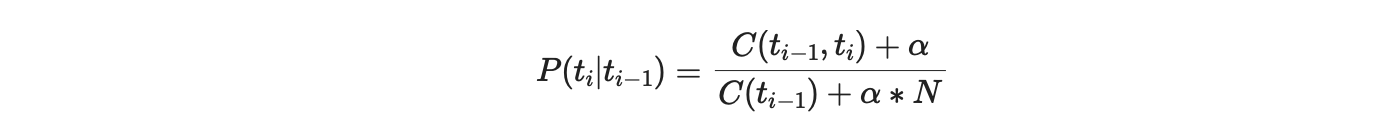



In [61]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    """
    Input:
        alpha: number used for smoothing
        tag_counts: a dictionary with tags as keys and counts as values
        transition_counts: transition_count for previous word and tag
    Output:
        A: transition probability matrix of dimention (num_tags, num_tags)
    """
    states = sorted(tag_counts.keys())
    num_tags = len(states)
    A = np.zeros((num_tags,num_tags))

    #get the unique transition tuples (previous POS, current POS)
    trans_keys = set(transition_counts.keys())

    for i in range(num_tags):
        for j in range(num_tags):

            # Initialize the count of the (prev POS, current POS)
            count = 0
            key = (states[i], states[j])

            if key in transition_counts:
                count = transition_counts[key]
            
            count_prev_tag = tag_counts[states[i]]

            A[i,j] = (count + alpha)/(count_prev_tag + alpha*num_tags)
    return A
    

In [62]:
alpha = 0.001
for i in range(46):
    tag_counts.pop(i,None)

A = create_transition_matrix(alpha, tag_counts, transition_counts)
print(f"A at row 0, col 0: {A[0,0]:.9f}")
print(f"A at row 3, col 1: {A[3,1]:.4f}")

A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02


__Emission Probability Matrix:__

- N is total number of words in vocabulary.
- $C(t_{i}, word_{i})$ is the number of times word_{i} was associated with tag{i} in training data.
- $C(t_{i})$ is the number of time tag_{i} was in the trainign data.
-  $\alpha$ is a smoothing parameter.

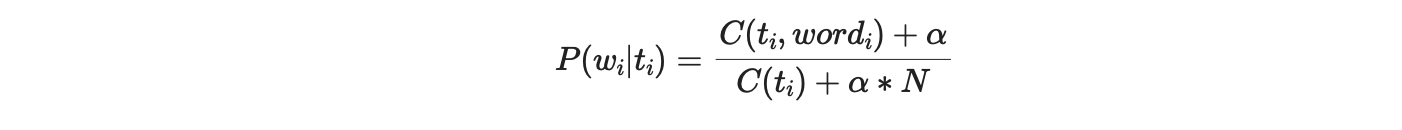



In [63]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    """
    Input
        alpha: number used for smoothing
        tag_counts: a dictionary with tags as keys and counts as values
        emission_count: a dictionary with (tag, word) as keys and counts as values.
        vocab: a dictionary with words as keys and index as values.
    Output:
        B: emission probability matrix of dimention (num_tags, len(vocab))
    """

    all_tags = sorted(tag_counts.keys())
    num_tags = len(tag_counts)
    num_words = len(vocab)
    B = np.zeros((num_tags, num_words))

    # get a set of all (POS, word)
    emis_keys = set(list(emission_counts.keys()))

    for i in range(num_tags):
        for j in range(num_words):
            count = 0

            key = (all_tags[i], vocab[j])
            if key in emis_keys:
                count = emission_counts[key]

            count_tag = tag_counts[all_tags[i]]
            B[i,j] = (count + alpha)/ (count_tag + alpha*num_words)
    
    return B

In [64]:
for i in range(46):
    tag_counts.pop(i,None)
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

B_sub = pd.DataFrame(B[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(B_sub)

View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              RBS            RP           SYM            TO            UH
RBS  2.106252e-06  2.106252e-06  2.106252e-06  2.106252e-06  2.106252e-06
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07
SYM  1.222838e-05  1.224061e-02  1.222838e-05  1.222838e-05  1.222838e-05
TO   4.468120e-08  4.468120e-08  4.468120e-08  4.468120e-08  4.468120e-08
UH   8.279722e-06  4.968661e-02  8.279722e-06  8.279722e-06  8.279722e-06


## Viterbi Algorithm and Dynamic Programming <a id='viter'></a>

### 1. Initialization <a id='init'></a>

Initializing two matrices:
- best_probs: Each cell contains the probability of going from one POS tag to a word in the corpus.
- best_path: A matrix that helps you trace through the best possible path in the corpus.

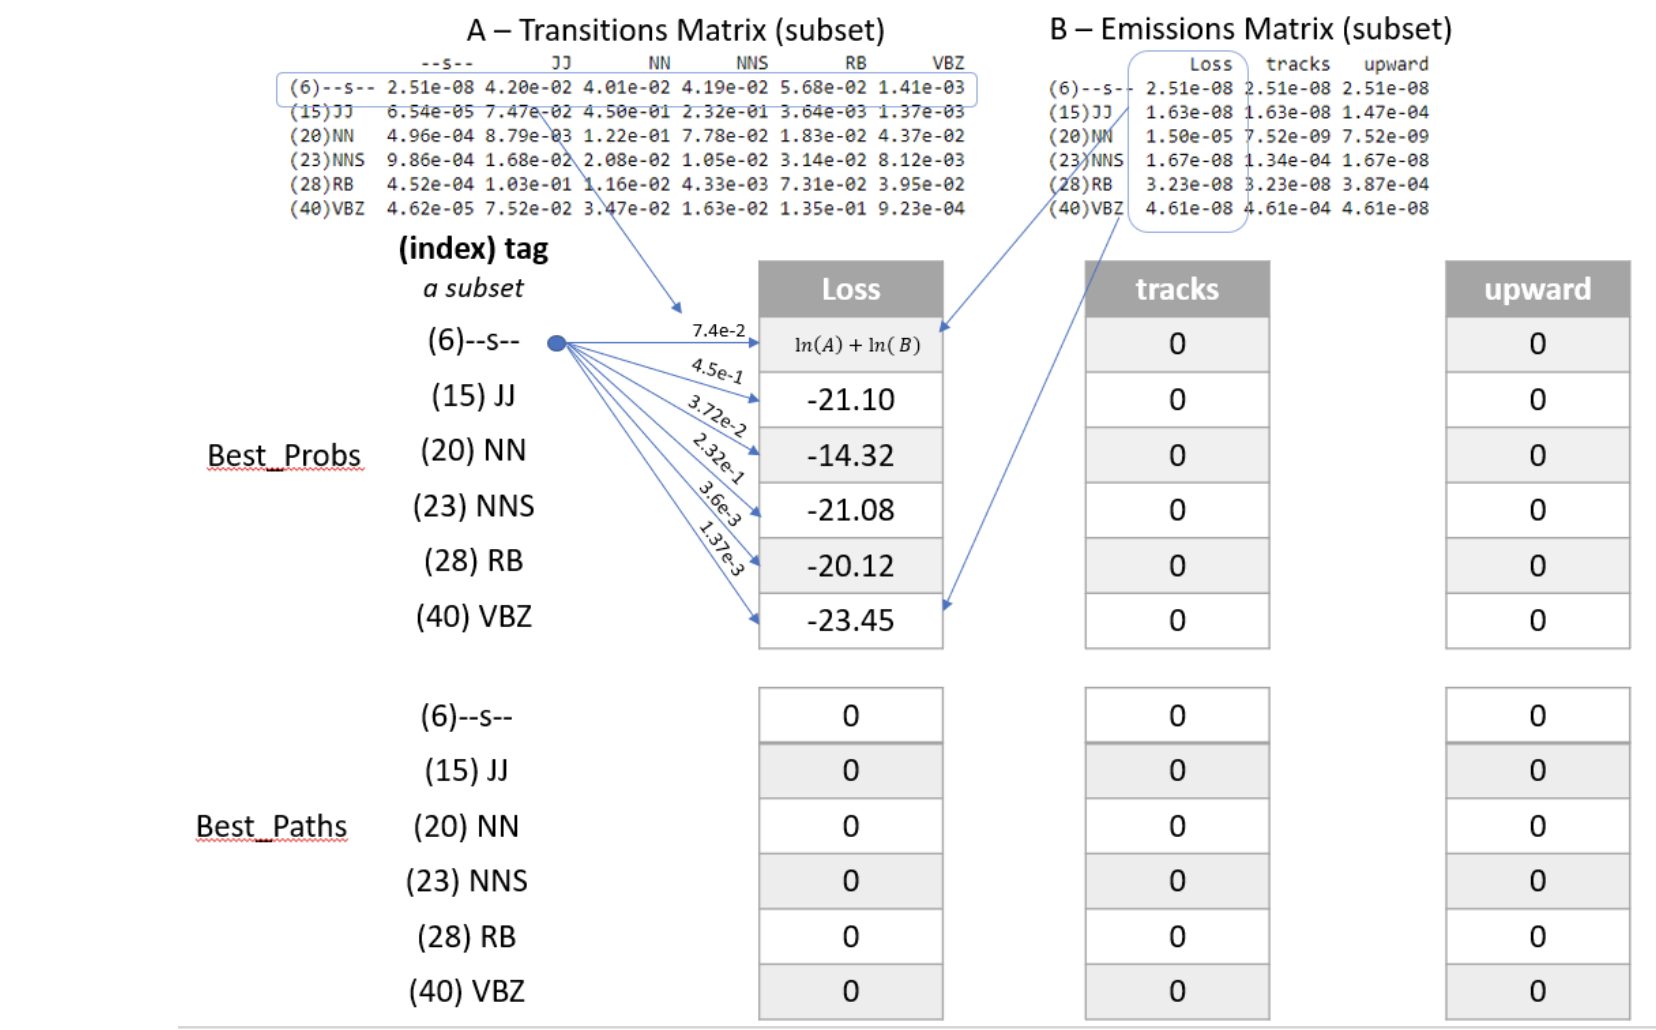

In [65]:
def initialize(states, tag_counts, A, B, corpus, vocab):
    '''
    Input: 
        states: a list of all possible POS
        tag_counts: a dictionary mapping each tag to its respective count
        A: Transition Matrix of dimension (num_tags, num_tags)
        B: Emission Matrix of dimension (num_tags, len(vocab))
        corpus: a sequence of words whose POS is to be identified in a list 
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        best_probs: matrix of dimension (num_tags, len(corpus)) of floats
        best_paths: matrix of dimension (num_tags, len(corpus)) of integers
    '''
    num_tags = len(tag_counts)
    # initialize best_probs matrix 
    best_probs = np.zeros((num_tags, len(corpus)))
    # initialize best_paths matrix
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)

    # define start token
    s_idx = states.index("--s--")

    for i in range(num_tags):
        # handle the special case when the transition from start token to POS tag i is zero
        if A[s_idx, i]==0:
            best_probs[i,0] = float("-inf")
        else:
            best_probs[i,0] = math.log(A[s_idx,i]) + math.log(B[i,vocab[corpus[0]]])

    return best_probs, best_paths 

In [66]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)


### 2. Feed Forward <a id='frwd'></a>

- The formula to compute the probability and path for the  ith word in the corpus, the prior word i-1 in the corpus, current POS tag j , and previous POS tag k is:

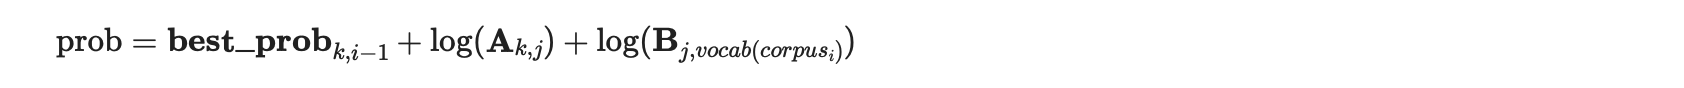

- where the $corpus_{i}$ is the word in the corpus at index $i$, and $vocab$ is the dictionary that gets the unique integer that represents a given word.

In [69]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab):
    '''
    Input: 
        A, B: The transiton and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initilized matrix of dimension (num_tags, len(corpus))
        best_paths: an initilized matrix of dimension (num_tags, len(corpus))
        vocab: a dictionary where keys are words in vocabulary and value is an index 
    Output: 
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    '''

    num_tags = best_probs.shape[0]

    # go through every word in the corpus starting from word 1
    for i in range(1,len(test_corpus)):
        # for each unique POS tag that the current word can be
        for j in range(num_tags):
            best_prob_i = float("-inf")

            # for each POS tag that the previous word can be:
            for k in range(num_tags):
                prob = best_probs[k,i-1] + math.log(A[k,j]) + math.log(B[j,vocab[test_corpus[i]]])
                if prob > best_prob_i:
                    best_prob_i = prob
                    best_path_i  = k 

            best_probs[j,i] = best_prob_i
            best_paths[j,i] = best_path_i
            
    return best_probs, best_paths

In [70]:
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab)

### 3. Feed Backward <a id='back'></a>

In [78]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    '''
    This function returns the best path.
    
    '''
    m = best_paths.shape[1]
    # initialize array z, same length as the corpus
    z = [None] * m
    num_tags = best_probs.shape[0]
    # initialize the best probability for the last word
    best_prob_for_last_word = float('-inf')
    # initialize pred array, same length as corpus
    pred = [None] * m
    # go through each POS tag for the last word (last column of best_probs)
    # in order to find the row (POS tag integer ID) 
    # with highest probability for the last word
    for k in range(num_tags):

        if best_probs[k,-1]>best_prob_for_last_word:
            best_prob_for_last_word = best_probs[k,-1]
            z[m - 1] = k
    
    pred[m - 1] = states[k]

    for i in range(len(corpus)-1, -1, -1):
        pos_tag_for_word_i = best_paths[np.argmax(best_probs[:,i]),i]
        z[i - 1] = best_paths[pos_tag_for_word_i,i]
        pred[i - 1] = states[pos_tag_for_word_i]

    return pred

In [80]:
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']


### Prediction

In [82]:
def compute_accuracy(pred, y):
    num_correct = 0
    total = 0

    for prediction,y in zip(pred, y):
        word_tag_tup = y.split()

        if len(word_tag_tup)!=2:
            continue

        word, tag = word_tag_tup
        if prediction == tag:
            num_correct += 1
        
        total += 1

    return num_correct/total

In [83]:
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

Accuracy of the Viterbi algorithm is 0.9528
